# 🔬 Test del Multiplicador de Lagrange (LM) de Engle para ARCH

El **Test del Multiplicador de Lagrange (LM)**, propuesto por Robert Engle (1982), es la prueba estándar para detectar la presencia de **Heterocedasticidad Condicional Autorregresiva (ARCH)** en los residuos de una serie de tiempo.

El ARCH implica que la varianza del error en el tiempo $t$ depende de los errores pasados al cuadrado, un fenómeno conocido como **clustering de volatilidad**.

## 1. 📝 Fundamento Teórico

### A. Hipótesis
El test está diseñado para probar si la varianza condicional, $\sigma_t^2$, es constante ($H_0$) o si es una función de los errores rezagados al cuadrado ($H_a$).

| Hipótesis | Descripción | Fórmula |
| :---: | :--- | :--- |
| **$H_0$ (Nula)** | No hay efectos ARCH de orden $q$. Homocedasticidad. | $H_0: \alpha_1 = \alpha_2 = \dots = \alpha_q = 0$ |
| **$H_a$ (Alternativa)** | Existe al menos un efecto ARCH de orden $q$. Heterocedasticidad. | $H_a: \exists \alpha_i \neq 0 \text{ for } i=1, \dots, q$ |

### B. Procedimiento (Regresión Auxiliar)

1.  **Estimación del Modelo de Media:** Se estima un modelo apropiado para la media (e.g., $ARIMA(p, d, q)$ u $OLS$) sobre la serie original ($y_t$) para obtener los **residuos** $\hat{\epsilon}_t$.

2.  **Cálculo de los Residuos al Cuadrado:** Se elevan los residuos al cuadrado ($\hat{\epsilon}_t^2$), que actúan como *proxy* de la varianza condicional $\sigma_t^2$.

3.  **Regresión Auxiliar:** Se corre una regresión lineal de los residuos al cuadrado sobre una constante y sus propios valores rezagados hasta el orden $q$.

    $$
    \hat{\epsilon}_t^2 = \alpha_0 + \alpha_1 \hat{\epsilon}_{t-1}^2 + \alpha_2 \hat{\epsilon}_{t-2}^2 + \dots + \alpha_q \hat{\epsilon}_{t-q}^2 + u_t
    $$

### C. Estadístico de Prueba

El estadístico del Test LM se calcula a partir del coeficiente de determinación ($R^2$) de la regresión auxiliar y el número de observaciones ($N$).

$$
LM = N \cdot R^2
$$

Bajo la hipótesis nula ($H_0$), el estadístico $LM$ sigue asintóticamente una distribución **Chi-cuadrado** ($\chi^2$) con $q$ grados de libertad.

$$
LM \sim \chi^2(q)
$$

## 2. 🚀 Importancia de la Aplicación (Pre-Modelado)

Es crucial aplicar este test a los residuos del modelo de media **antes** de finalizar la especificación, especialmente en el análisis de datos financieros, por tres razones principales:

1.  **Inferencia Válida:** Si el test LM rechaza $H_0$, las varianzas y covarianzas de los estimadores OLS/ARIMA son **inconsistentes**. Esto significa que los errores estándar y, por lo tanto, las pruebas de significancia ($t$-ratios) son incorrectas.
2.  **Necesidad de GARCH:** La detección de ARCH **justifica la complejidad** adicional de utilizar modelos de la familia GARCH (Generalized ARCH) o EGARCH, que están diseñados específicamente para modelar la varianza condicional dinámica.
3.  **Modelado de Riesgo:** En finanzas, la varianza es una medida de riesgo. Un modelo sin ARCH/GARCH subestimará el riesgo durante los periodos de *clustering* de volatilidad, impactando negativamente las estrategias de Value-at-Risk (VaR) y optimización de carteras.

---


## 3. 🐍 Código Python para el Test LM de Engle

A continuación, se presenta el código listo para ejecutar en un entorno Jupyter/Python utilizando la librería `statsmodels`.

In [2]:
import pandas as pd
import numpy as np
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf

# --- PARÁMETROS ---
TICKER = 'TSLA' # Ejemplo de alta volatilidad
Q_LAGS = 10     # Orden ARCH (q) a testear
ALPHA = 0.05    # Nivel de significancia

# --- 1. Obtener Data y Calcular Retornos ---
try:
    print(f"Descargando data de {TICKER}...")
    data = yf.download(TICKER, start='2018-01-01', end='2024-01-01', progress=False)
    retornos = np.log(data['Adj Close']).diff().dropna()
    print(f"✅ Data cargada. Total de obs: {len(retornos)}.")
except Exception as e:
    print(f"❌ Error al descargar data: {e}. Usando data simulada.")
    # Si falla, simular data con ARCH(1)
    T, a0, a1 = 500, 0.1, 0.5
    e, sigma2, z = np.zeros(T), np.zeros(T), np.random.normal(0, 1, T)
    for t in range(1, T):
        sigma2[t] = a0 + a1 * (e[t-1]**2)
        e[t] = np.sqrt(sigma2[t]) * z[t]
    retornos = pd.Series(e[1:], name='Simulated_Returns')

# --- 2. Estimar Modelo de Media (ARIMA(1,0,0) es común para retornos) ---
print("-" * 50)
print("Ajustando modelo de media ARIMA(1, 0, 0) para obtener residuos...")
try:
    modelo_media = ARIMA(retornos, order=(1, 0, 0)).fit()
    residuos = modelo_media.resid
    print(f"✅ Modelo ajustado. Residuos obtenidos (N={len(residuos)}).")
except Exception as e:
    print(f"❌ Error al ajustar ARIMA: {e}. Usando los retornos directamente como residuos (asumiendo media cero).")
    residuos = retornos

# --- 3. Aplicar el Test LM de Engle ---
print("-" * 50)
print(f"Iniciando Test LM de Engle para ARCH(q={Q_LAGS})...")

# El resultado es: (LM-statistic, p-value, F-statistic, F-p-value)
lm_test_result = het_arch(residuos, nlags=Q_LAGS)

lm_stat = lm_test_result[0]
p_value = lm_test_result[1]

# --- 4. Interpretación de Resultados ---
print(f"\n📈 Resultados del Test LM (ARCH({Q_LAGS})):")
print(f"   - Estadístico LM (N * R^2): {lm_stat:.4f}")
print(f"   - Valor p (p-value, $\chi^2({Q_LAGS})$): {p_value:.4f}")
print("-" * 50)

if p_value < ALPHA:
    print(f"*** RECHAZO H0 *** (p-value < {ALPHA})")
    print("  Conclusión: Existe evidencia significativa de efectos ARCH.")
    print("  Acción Recomendada: Se debe especificar un modelo GARCH.")
else:
    print(f"*** NO RECHAZO H0 *** (p-value > {ALPHA})")
    print("  Conclusión: No hay evidencia de efectos ARCH. Se asume homocedasticidad.")

<>:56: SyntaxWarning: invalid escape sequence '\c'
<>:56: SyntaxWarning: invalid escape sequence '\c'
C:\Users\delhy.py\AppData\Local\Temp\ipykernel_1152\2729581155.py:56: SyntaxWarning: invalid escape sequence '\c'
  print(f"   - Valor p (p-value, $\chi^2({Q_LAGS})$): {p_value:.4f}")


Descargando data de TSLA...
❌ Error al descargar data: 'Adj Close'. Usando data simulada.
--------------------------------------------------
Ajustando modelo de media ARIMA(1, 0, 0) para obtener residuos...
✅ Modelo ajustado. Residuos obtenidos (N=499).
--------------------------------------------------
Iniciando Test LM de Engle para ARCH(q=10)...

📈 Resultados del Test LM (ARCH(10)):
   - Estadístico LM (N * R^2): 78.4913
   - Valor p (p-value, $\chi^2(10)$): 0.0000
--------------------------------------------------
*** RECHAZO H0 *** (p-value < 0.05)
  Conclusión: Existe evidencia significativa de efectos ARCH.
  Acción Recomendada: Se debe especificar un modelo GARCH.


--------------------------------------------------
Validación Visual: ACF de los Residuos al Cuadrado


<Figure size 1000x400 with 0 Axes>

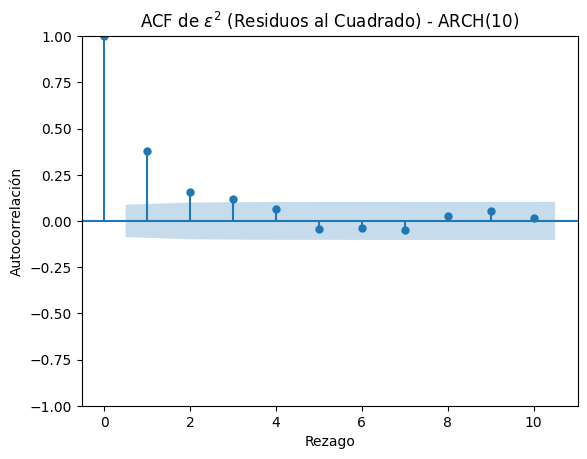

In [3]:
# --- Nueva Sección para Validación Visual ---
print("-" * 50)
print("Validación Visual: ACF de los Residuos al Cuadrado")

# Graficar la Función de Autocorrelación (ACF) de los residuos al cuadrado
plt.figure(figsize=(10, 4))
plot_acf(residuos.pow(2), lags=Q_LAGS, title=f'ACF de $\epsilon^2$ (Residuos al Cuadrado) - ARCH({Q_LAGS})')
plt.xlabel('Rezago')
plt.ylabel('Autocorrelación')
plt.show()

### Interpretación Visual del ACF
 * Si las barras se extienden significativamente fuera de las bandas de confianza azul, existe **autocorrelación** en los residuos al cuadrado.
* Esta autocorrelación es la manifestación visual de los efectos **ARCH** (dependencia de la volatilidad pasada).
 * En tu caso (con $p$-value=0.0000), deberías ver varias barras (rezagos) que cruzan las bandas, confirmando visualmente el resultado del Test LM.